In [54]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from libpysal.weights import Kernel
from esda.moran import Moran

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score, train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler

In [2]:
# set seaborn theme
sns.set_theme(style='darkgrid')

In [3]:
loc_gdf = gpd.read_file('data/AQMS_loc.shp')

# Initialise

In [ ]:
# Read in all the data

AQMS_df = pd.read_csv('data/hourly.csv')
Rd_gdf = gpd.read_file('data/london_Road.shp')
Gsp_gdf = gpd.read_file('data/LD_GreenSpace.shp')
cond = pd.read_csv('data/cond_hourly.csv')

In [ ]:
# reindex loc_gdf and set buffer zones around each site (1km)

loc_gdf = loc_gdf.set_index('siteid')
loc_gdf['buffer_1km'] = loc_gdf['geometry'].buffer(1000)

In [ ]:
Rd_gdf.head()

In [ ]:
for typ in Rd_gdf['function'].unique():
    print('Number of ' + typ + ': ', Rd_gdf[Rd_gdf['function'] == typ].shape[0])

In [ ]:
# Get all green spaces
Gsp = Gsp_gdf['geometry'].unary_union

# Get all types of roads
Rd = {}
for typ in Rd_gdf['function'].unique():
    Rd[typ] = Rd_gdf[Rd_gdf['function'] == typ].loc[:, 'geometry'].unary_union
Rd

In [ ]:
del Gsp_gdf, Rd_gdf

In [ ]:
loc_gdf['Gsp'] = loc_gdf['buffer_1km'].intersection(Gsp)
for key in Rd.keys():
    loc_gdf[key] = loc_gdf['buffer_1km'].intersection(Rd[key])

loc_gdf.head()

In [ ]:
del Rd

In [ ]:
# Rename columns
loc_gdf.rename(columns={'Restricted Local Access Road': 'RLA_Rd', 
                        'Minor Road': 'Mi_Rd',
                        'A Road': 'A_Rd',
                        'Local Road': 'L_Rd',
                        'B Road': 'B_Rd',
                        'Local Access Road': 'LA_Rd',
                        'Secondary Access Road': 'SA_Rd',
                        'Motorway': 'Mo_Rd'}, inplace=True)

loc_gdf.columns

In [ ]:
# Get all near-road green spaces
Rd_type = loc_gdf.columns[4:]
for col in Rd_type:
    loc_gdf['n'+col+'_Gsp'] = loc_gdf['Gsp'].intersection(loc_gdf[col].buffer(50))

In [ ]:
loc_gdf.head()

In [ ]:
# london boundary read in
london = gpd.read_file('data/london_boundary.shp')

In [ ]:
# visualise all the sites on the map
fig,ax = plt.subplots(1, figsize=(15,13))

london.plot(color='lightgrey', ax=ax)
loc_gdf['buffer_1km'].plot(color='silver', ax=ax)
loc_gdf['geometry'].plot(markersize=10, marker='^', color='blue', 
                         label='Air quality monitoring site', ax=ax)

ax.axis('off')

legend=ax.legend(loc='best',shadow=True,fontsize=15)

#plt.savefig('sample1.png',facecolor='black',dpi=500)
plt.show()

There are some buffers that seem to be very close to each other.

In [ ]:
# add a column that specifies the shortest distance of a site to its nearest neighbour
loc_gdf['min_dis'] = pd.Series(dtype='float64')
for index, row in loc_gdf.iterrows():
    dis = []
    for i, v in loc_gdf['geometry'].iteritems():
        dis.append(row['geometry'].distance(v))
    dis.remove(0)
    loc_gdf.loc[index, 'min_dis'] = min(dis)

In [ ]:
# list sites that are close to each other (within 1.5km)
loc_gdf[loc_gdf['min_dis']<=1500]

In [ ]:
# check their readings' descriptive statistics
AQMS_df[AQMS_df['Site'].isin(['BL0', 'CD9', 'GR4', 'GB0'])].groupby('Site').describe()

In [ ]:
stats.ttest_rel(AQMS_df[AQMS_df['Site']=='BL0'].Value.values,
                AQMS_df[AQMS_df['Site']=='CD9'].Value.values)

In [ ]:
stats.ttest_rel(AQMS_df[AQMS_df['Site']=='GR4'].Value.values,
                AQMS_df[AQMS_df['Site']=='GB0'].Value.values)

Both indicate that we should reject H0, meaning the two datasets are statistically significantly different.

In [ ]:
# revmove them from the list
#loc_gdf.drop(['BL0','GR4'], inplace=True)

In [ ]:
# get areas and edge lengths of green spaces 
loc_gdf['Gsp_area'] = loc_gdf['Gsp'].area
loc_gdf['Gsp_edge'] = loc_gdf['Gsp'].length

In [ ]:
# get road lengths of each type and nRd gsp area percentages
for col in Rd_type:
    loc_gdf[col+'_len'] = loc_gdf[col].length
    loc_gdf['pct_n'+col+'_Gsp'] = loc_gdf['n'+ col +'_Gsp'].area / loc_gdf['Gsp_area'] * 100

In [ ]:
loc_gdf.columns

In [ ]:
loc_gdf[[col+'_len' for col in Rd_type]].sum(axis=1)

In [ ]:
loc_gdf['Gsp_per_tRd_len'] = loc_gdf['Gsp_area'] / loc_gdf[[col+'_len' for col in Rd_type]].sum(axis=1)

In [ ]:
loc_gdf.info()

In [ ]:
exp_names = loc_gdf.columns[21:].tolist()
exp_names

In [ ]:
# merge PM reading and site geogemetry data
df = pd.merge(AQMS_df, loc_gdf, left_on='Site', right_index=True)
df.info()

In [ ]:
# drop irrelevant columns
df.drop(['sitename', 'geometry', 'buffer_1km', 'Gsp', 'min_dis'], axis=1, inplace=True)
df.drop(Rd_type , axis=1, inplace=True)
df.drop(['n'+rd+'_Gsp' for rd in Rd_type], axis=1, inplace=True)

df.info()

In [ ]:
# merge with conditional variables
df = df.merge(cond, on='ReadingDateTime')
df.info()

In [ ]:
cond_names = df.columns[-3:].tolist()
cond_names

In [ ]:
df[exp_names + cond_names].describe()

In [ ]:
df.to_csv('temp_data.csv', index=False)

# Temporarily save

In [4]:
df = pd.read_csv('temp_data.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183960 entries, 0 to 183959
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Site             183960 non-null  object 
 1   ReadingDateTime  183960 non-null  object 
 2   Value            183960 non-null  float64
 3   Gsp_area         183960 non-null  float64
 4   Gsp_edge         183960 non-null  float64
 5   RLA_Rd_len       183960 non-null  float64
 6   pct_nRLA_Rd_Gsp  183960 non-null  float64
 7   Mi_Rd_len        183960 non-null  float64
 8   pct_nMi_Rd_Gsp   183960 non-null  float64
 9   A_Rd_len         183960 non-null  float64
 10  pct_nA_Rd_Gsp    183960 non-null  float64
 11  L_Rd_len         183960 non-null  float64
 12  pct_nL_Rd_Gsp    183960 non-null  float64
 13  B_Rd_len         183960 non-null  float64
 14  pct_nB_Rd_Gsp    183960 non-null  float64
 15  LA_Rd_len        183960 non-null  float64
 16  pct_nLA_Rd_Gsp   183960 non-null  floa

In [6]:
# covert the DateTime column to numpy.datetime variable
df['ReadingDateTime'] = pd.to_datetime(df['ReadingDateTime'], format="%d/%m/%Y %H:%M")
df.rename(columns={'ReadingDateTime':'DateTime'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183960 entries, 0 to 183959
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Site             183960 non-null  object        
 1   DateTime         183960 non-null  datetime64[ns]
 2   Value            183960 non-null  float64       
 3   Gsp_area         183960 non-null  float64       
 4   Gsp_edge         183960 non-null  float64       
 5   RLA_Rd_len       183960 non-null  float64       
 6   pct_nRLA_Rd_Gsp  183960 non-null  float64       
 7   Mi_Rd_len        183960 non-null  float64       
 8   pct_nMi_Rd_Gsp   183960 non-null  float64       
 9   A_Rd_len         183960 non-null  float64       
 10  pct_nA_Rd_Gsp    183960 non-null  float64       
 11  L_Rd_len         183960 non-null  float64       
 12  pct_nL_Rd_Gsp    183960 non-null  float64       
 13  B_Rd_len         183960 non-null  float64       
 14  pct_nB_Rd_Gsp    183

In [8]:
cond_names = df.columns[-3:].tolist()
cond_names

['bp_mean', 'tmp_mean', 'Prec_mean']

In [9]:
var_names = df.columns[3:-3].tolist()
var_names

['Gsp_area',
 'Gsp_edge',
 'RLA_Rd_len',
 'pct_nRLA_Rd_Gsp',
 'Mi_Rd_len',
 'pct_nMi_Rd_Gsp',
 'A_Rd_len',
 'pct_nA_Rd_Gsp',
 'L_Rd_len',
 'pct_nL_Rd_Gsp',
 'B_Rd_len',
 'pct_nB_Rd_Gsp',
 'LA_Rd_len',
 'pct_nLA_Rd_Gsp',
 'SA_Rd_len',
 'pct_nSA_Rd_Gsp',
 'Mo_Rd_len',
 'pct_nMo_Rd_Gsp',
 'Gsp_per_tRd_len']

In [10]:
loc_gdf = loc_gdf.set_index('siteid')

In [11]:
loc_gdf = pd.merge(df.groupby('Site').mean()[var_names], loc_gdf, left_index=True, right_index=True)

In [12]:
# kernel weight matrix for the sites
weight = Kernel.from_dataframe(loc_gdf, geom_col='geometry', function='gaussian')

In [13]:
for var in var_names:
    moran_temp = Moran(loc_gdf[var].values, weight)
    print("Global Moran's I for " + var + ' is ', round(moran_temp.I, 5), 
          ' p-value: ', round(moran_temp.p_norm, 5))

Global Moran's I for Gsp_area is  0.15159  p-value:  0.00058
Global Moran's I for Gsp_edge is  0.01709  p-value:  0.25236
Global Moran's I for RLA_Rd_len is  0.12384  p-value:  0.00302
Global Moran's I for pct_nRLA_Rd_Gsp is  0.01687  p-value:  0.25391
Global Moran's I for Mi_Rd_len is  0.2266  p-value:  0.0
Global Moran's I for pct_nMi_Rd_Gsp is  0.08229  p-value:  0.024
Global Moran's I for A_Rd_len is  0.12446  p-value:  0.00291
Global Moran's I for pct_nA_Rd_Gsp is  0.07157  p-value:  0.03805
Global Moran's I for L_Rd_len is  0.192  p-value:  4e-05
Global Moran's I for pct_nL_Rd_Gsp is  0.16652  p-value:  0.00022
Global Moran's I for B_Rd_len is  0.27624  p-value:  0.0
Global Moran's I for pct_nB_Rd_Gsp is  0.11358  p-value:  0.00525
Global Moran's I for LA_Rd_len is  0.2049  p-value:  1e-05
Global Moran's I for pct_nLA_Rd_Gsp is  0.11674  p-value:  0.00444
Global Moran's I for SA_Rd_len is  0.10293  p-value:  0.00907
Global Moran's I for pct_nSA_Rd_Gsp is  0.00823  p-value:  0.320

<AxesSubplot:>

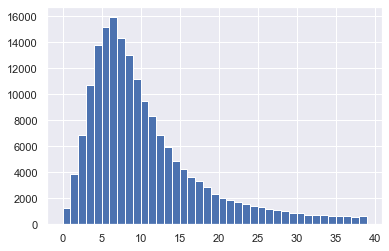

In [14]:
df['Value'].hist(bins=list(range(40)))

<AxesSubplot:>

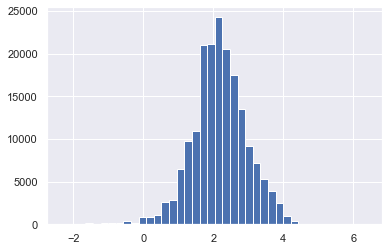

In [15]:
df['log_Value'] = np.log(df['Value'])
df['log_Value'].hist(bins=40)

<AxesSubplot:xlabel='hour'>

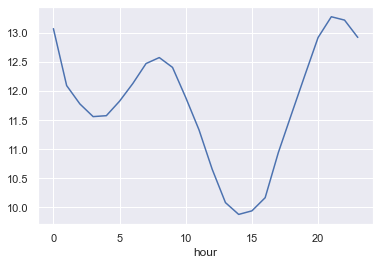

In [16]:
df['hour'] = df['DateTime'].dt.hour
df.groupby('hour').mean()['Value'].plot()

<AxesSubplot:xlabel='dayofweek'>

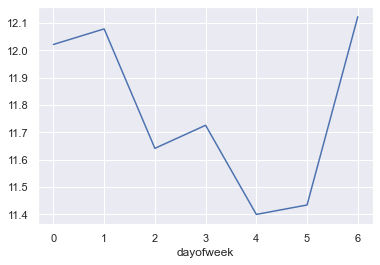

In [17]:
df['dayofweek'] = df['DateTime'].dt.dayofweek
df.groupby('dayofweek').mean()['Value'].plot()

<AxesSubplot:xlabel='dayofmonth'>

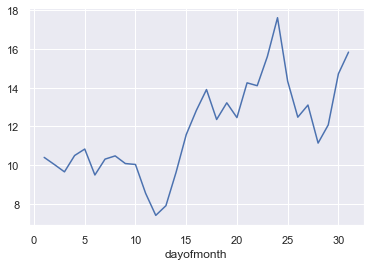

In [18]:
df['dayofmonth'] = df['DateTime'].dt.day
df.groupby('dayofmonth').mean()['Value'].plot()

In [19]:
def get_importance(reg, features, target, feature_names, rep=50, method='r2'):
    mean = []
    std = []
    importance = permutation_importance(reg, features, target, n_repeats=rep,
                                        random_state=25, scoring=method)
    for i in range(len(feature_names)):
        mean.append(round(importance.importances_mean[i], 5))
        std.append(round(importance.importances_std[i], 5))
    return mean, std

In [114]:
def get_cv_score(reg, features, target, iter=50, split=10, method='r2'):
    score = []
    for i in range(iter):
        kf = KFold(n_splits=split, shuffle=True, random_state=i)
        cv = cross_val_score(reg, features, target, cv=kf, scoring=method).tolist()
        score = score + cv
    
    return (np.mean(score), np.std(score))

In [24]:
exp_names = []
for i in range(9):
    exp_names.append(df.columns[2*i+4])
exp_names.append('Gsp_per_tRd_len')
exp_names

['Gsp_edge',
 'pct_nRLA_Rd_Gsp',
 'pct_nMi_Rd_Gsp',
 'pct_nA_Rd_Gsp',
 'pct_nL_Rd_Gsp',
 'pct_nB_Rd_Gsp',
 'pct_nLA_Rd_Gsp',
 'pct_nSA_Rd_Gsp',
 'pct_nMo_Rd_Gsp',
 'Gsp_per_tRd_len']

In [55]:
scaler = MinMaxScaler()

In [60]:
reg = LinearRegression()
var = exp_names + cond_names

ap_X = df[var].values
ap_y = df['log_Value'].values

ap_X_train, ap_X_test, ap_y_train, ap_y_test = train_test_split(ap_X, ap_y, shuffle=True, random_state=25)
#ap_y_train = ap_y_train.reshape(-1,1)
#ap_y_test = ap_y_test.reshape(-1,1)
ap_X_train = scaler.fit_transform(ap_X_train)
#ap_y_train = scaler.fit_transform(ap_y_train)
ap_X_test = scaler.fit_transform(ap_X_test)
#ap_y_test = scaler.fit_transform(ap_y_test)
reg.fit(ap_X_train, ap_y_train)

get_importance(reg, ap_X_test, ap_y_test, var)

([0.00121,
  0.00067,
  0.02643,
  0.00467,
  0.01889,
  0.00172,
  -0.0,
  0.00771,
  0.03257,
  0.00939,
  0.11792,
  0.04712,
  0.00164],
 [0.00021,
  0.00018,
  0.00138,
  0.00036,
  0.00086,
  0.00022,
  2e-05,
  0.0006,
  0.00109,
  0.00062,
  0.00255,
  0.00137,
  0.00025])

In [66]:
reg.score(ap_X_test, ap_y_test)

0.1072880075890762

In [29]:
moran = []
for time in df['DateTime'].unique():
    moran_temp = Moran(df[df['DateTime']==time].log_Value.values, weight)
    moran.append([round(moran_temp.I, 5), round(moran_temp.p_norm, 5)])
moran_df = pd.DataFrame(df['DateTime'].unique(), columns=['DateTime'])
moran_df[['moran', 'p-value']] = moran
moran_df.head()

,DateTime,moran,p-value
0,2019-01-01 00:00:00,0.10500,0.00818
1,2019-01-01 01:00:00,0.14475,0.00089
2,2019-01-01 02:00:00,0.03614,0.14164
3,2019-01-01 03:00:00,0.02612,0.19403
4,2019-01-01 04:00:00,-0.02530,0.67344


In [30]:
moran_df['hour'] = moran_df['DateTime'].dt.hour

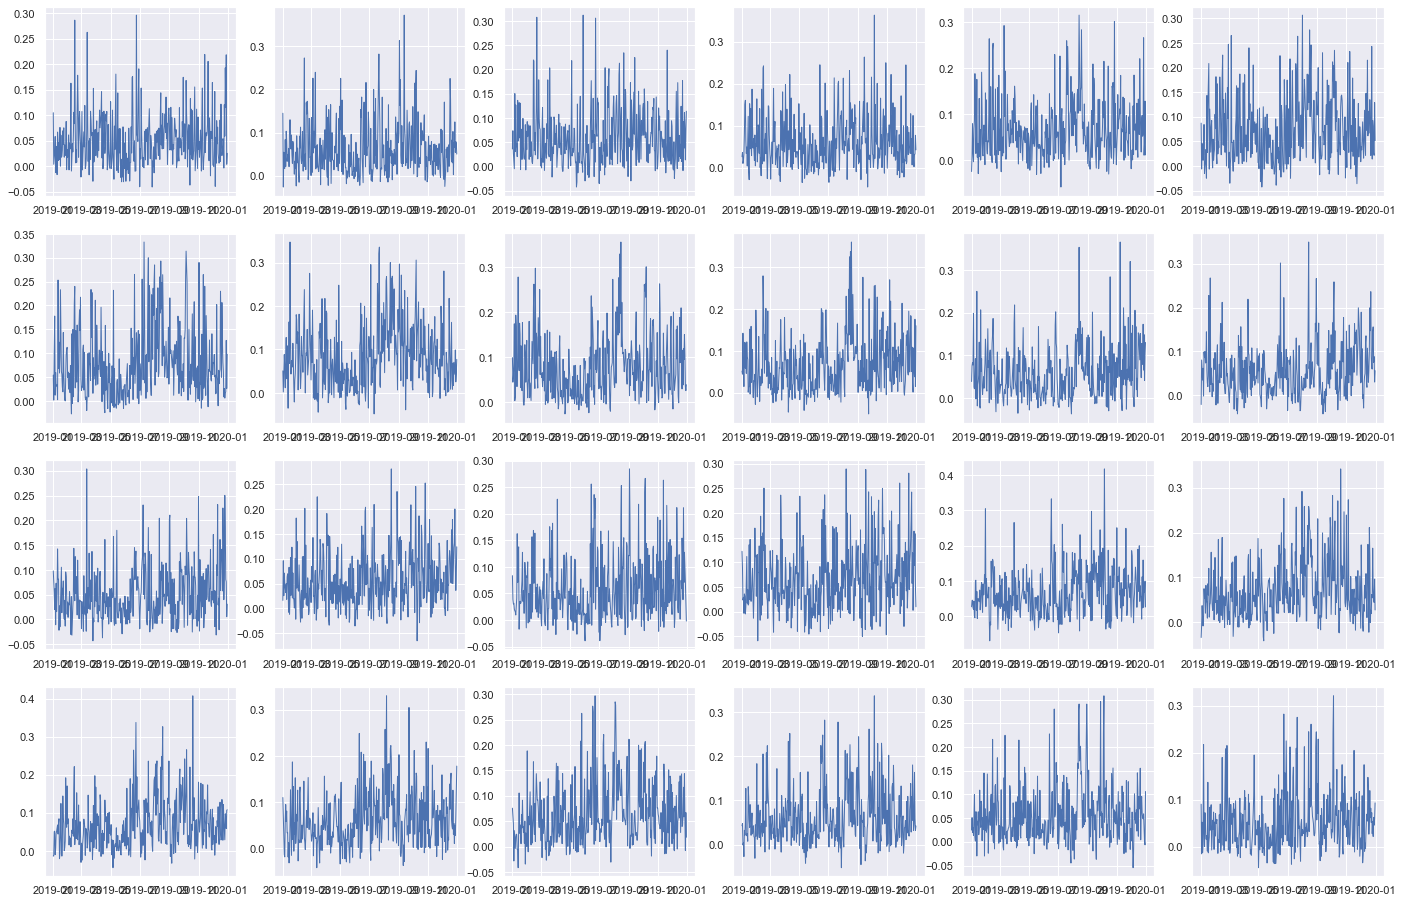

In [32]:
fig,ax = plt.subplots(4, 6, figsize=(24,16))
i = 0
for hour in range(24):
    sns.lineplot(x=moran_df['DateTime'].dt.date.unique(), 
                 y=moran_df[moran_df['hour']==hour].moran.values, 
                 ax=ax[i//6, i%6], linewidth=1)
    i+=1
plt.show()

In [67]:
h_fi = []
h_score = []
h_coef = []
for hour in df['hour'].unique():
    X = df[df['hour']==hour].loc[:,var].values
    y = df[df['hour']==hour].loc[:,'log_Value'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=25)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    reg.fit(X_train, y_train)
    
    fi_mean, fi_std = get_importance(reg, X_test, y_test, feature_names=var)
    h_fi.append(fi_mean + fi_std)
    
    h_score.append(reg.score(X_test, y_test))
    
    coef = reg.coef_.tolist()
    coef.append(reg.intercept_)
    h_coef.append(coef)
    
h_fi = pd.DataFrame(h_fi, columns=['fi_' + elem for elem in var] + ['fi_std_' + elem for elem in var])
h_score = pd.DataFrame(h_score, columns=['r2'])
h_coef = pd.DataFrame(h_coef, columns=var+['intercept'])

In [68]:
h_reg = pd.concat([h_coef, h_score, h_fi], axis=1)
h_reg

,Gsp_edge,pct_nRLA_Rd_Gsp,pct_nMi_Rd_Gsp,pct_nA_Rd_Gsp,pct_nL_Rd_Gsp,pct_nB_Rd_Gsp,pct_nLA_Rd_Gsp,pct_nSA_Rd_Gsp,pct_nMo_Rd_Gsp,Gsp_per_tRd_len,...,fi_std_pct_nA_Rd_Gsp,fi_std_pct_nL_Rd_Gsp,fi_std_pct_nB_Rd_Gsp,fi_std_pct_nLA_Rd_Gsp,fi_std_pct_nSA_Rd_Gsp,fi_std_pct_nMo_Rd_Gsp,fi_std_Gsp_per_tRd_len,fi_std_bp_mean,fi_std_tmp_mean,fi_std_Prec_mean
0,-0.249580,0.019709,0.197591,0.282078,0.501276,-0.279105,0.156543,0.084675,-0.276696,0.654455,...,0.00422,0.00893,0.00527,0.00209,0.00120,0.00243,0.00869,0.00955,0.01005,0.00313
1,-0.122830,0.056379,0.311483,-0.098501,0.404604,-0.199157,0.016054,0.055459,-0.370120,0.547443,...,0.00143,0.00650,0.00353,0.00020,0.00075,0.00330,0.00666,0.01002,0.00810,0.00060
2,-0.171898,0.113791,0.338362,-0.044415,0.434036,-0.220684,-0.017007,0.117264,-0.350198,0.624501,...,0.00058,0.00774,0.00352,0.00021,0.00142,0.00319,0.00858,0.00972,0.00796,0.00211
3,-0.108930,0.091671,0.337894,-0.063407,0.414364,-0.216735,0.018730,0.095209,-0.332369,0.546446,...,0.00087,0.00697,0.00357,0.00025,0.00124,0.00267,0.00609,0.01166,0.00785,0.00136
4,-0.104885,0.080439,0.334871,-0.120938,0.391597,-0.199034,-0.019386,0.051629,-0.353013,0.485966,...,0.00157,0.00676,0.00298,0.00027,0.00062,0.00303,0.00627,0.01091,0.00763,0.00171
5,-0.080121,0.054112,0.336874,-0.132599,0.256281,-0.148217,0.079714,-0.056309,-0.395243,0.359861,...,0.00167,0.00476,0.00237,0.00102,0.00073,0.00374,0.00409,0.00971,0.00713,0.00179
6,-0.084350,-0.036651,0.339571,-0.087579,0.193732,-0.094652,0.006633,-0.113829,-0.440121,0.291823,...,0.00119,0.00379,0.00136,0.00008,0.00169,0.00375,0.00353,0.00991,0.00608,0.00226
7,-0.107744,-0.071498,0.328023,-0.126570,0.241393,-0.056662,-0.033078,-0.129786,-0.458162,0.292361,...,0.00185,0.00448,0.00091,0.00050,0.00188,0.00397,0.00375,0.01130,0.00637,0.00288
8,-0.148203,-0.052443,0.295394,-0.015986,0.247208,-0.072319,0.008524,-0.159571,-0.455258,0.281607,...,0.00022,0.00436,0.00114,0.00012,0.00225,0.00372,0.00393,0.00993,0.00532,0.00282
9,-0.231954,-0.009656,0.288525,0.056102,0.279305,-0.086204,-0.006701,-0.179749,-0.492599,0.343624,...,0.00076,0.00481,0.00107,0.00010,0.00263,0.00545,0.00517,0.01003,0.00508,0.00033


<AxesSubplot:>

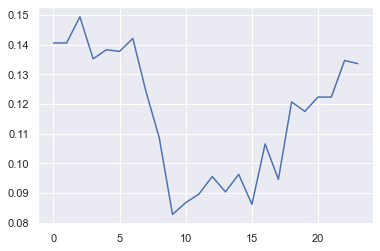

In [69]:
h_reg['r2'].plot()

No handles with labels found to put in legend.


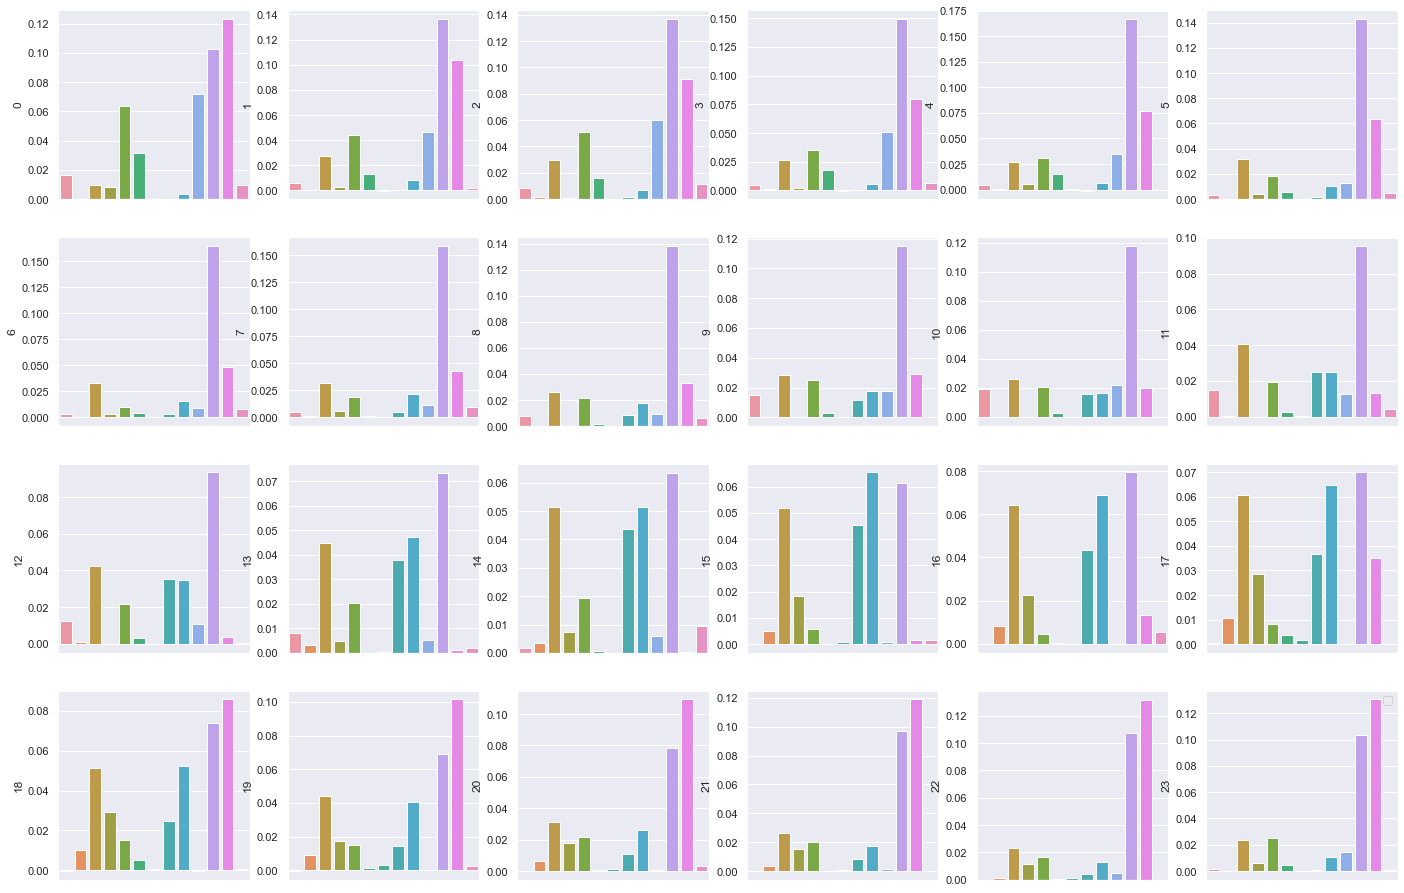

In [70]:
fig, ax = plt.subplots(4, 6, figsize=(24, 16))
i = 0
for hour in range(24):
    g = sns.barplot(x=['fi_' + elem for elem in var], y=h_reg.loc[hour, ['fi_' + elem for elem in var]],
                    ax=ax[i//6, i%6])
    g.set(xticklabels=[])
    i += 1
plt.legend()
plt.show()

In [40]:
# set up a new column for month information
df['month'] = df['DateTime'].dt.month

In [41]:
moran_df['month'] = moran_df['DateTime'].dt.month

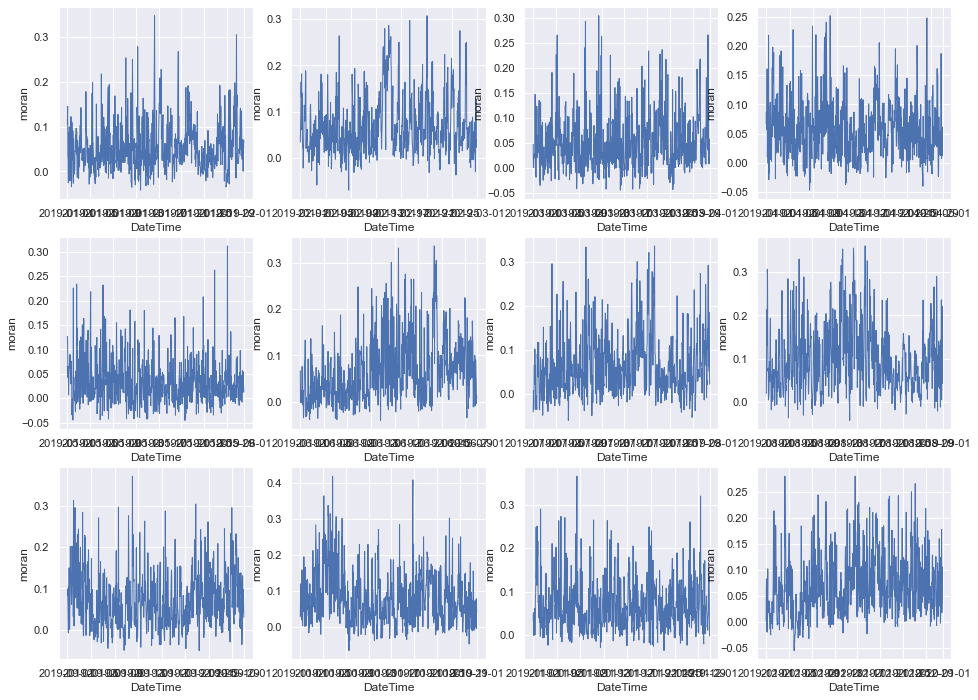

In [42]:
fig,ax = plt.subplots(3, 4, figsize=(16,12))
i = 0
for month in range(1,13):
    sns.lineplot(x='DateTime', y='moran', data=moran_df[moran_df['month']==month],
                 ax=ax[i//4, i%4], linewidth=1)
    i+=1
plt.show()

In [71]:
m_fi = []
m_score = []
m_coef = []
for month in df['month'].unique():
    X = df[df['month']==month].loc[:, var].values
    y = df[df['month']==month].loc[:, 'log_Value'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=25)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    reg.fit(X_train, y_train)
    
    fi_mean, fi_std = get_importance(reg, X_test, y_test, feature_names=var)
    m_fi.append(fi_mean + fi_std)

    m_score.append(reg.score(X_test, y_test))
    
    coef = reg.coef_.tolist()
    coef.append(reg.intercept_)
    m_coef.append(coef)
    
m_fi = pd.DataFrame(m_fi, columns=['fi_' + elem for elem in var] + ['fi_std_' + elem for elem in var])
m_score = pd.DataFrame(m_score, columns=['r2'])
m_coef = pd.DataFrame(m_coef, columns=var+['intercept'])

In [72]:
m_reg = pd.concat([m_coef, m_score, m_fi], axis=1)
m_reg

,Gsp_edge,pct_nRLA_Rd_Gsp,pct_nMi_Rd_Gsp,pct_nA_Rd_Gsp,pct_nL_Rd_Gsp,pct_nB_Rd_Gsp,pct_nLA_Rd_Gsp,pct_nSA_Rd_Gsp,pct_nMo_Rd_Gsp,Gsp_per_tRd_len,...,fi_std_pct_nA_Rd_Gsp,fi_std_pct_nL_Rd_Gsp,fi_std_pct_nB_Rd_Gsp,fi_std_pct_nLA_Rd_Gsp,fi_std_pct_nSA_Rd_Gsp,fi_std_pct_nMo_Rd_Gsp,fi_std_Gsp_per_tRd_len,fi_std_bp_mean,fi_std_tmp_mean,fi_std_Prec_mean
0,0.074294,-0.149432,0.275505,-0.189121,0.101499,0.034241,-0.120561,-0.025204,-0.348499,-0.007108,...,0.00172,0.00131,0.00041,0.00108,0.00018,0.00281,0.00007,0.00844,0.01590,0.00021
1,-0.061811,-0.210638,0.177275,-0.184744,0.142129,-0.006665,-0.091788,-0.204112,-0.387034,-0.122010,...,0.00153,0.00149,0.00008,0.00068,0.00198,0.00269,0.00101,0.01707,0.00241,0.00028
2,0.049749,-0.078990,0.213697,-0.155291,0.228947,-0.122362,0.055563,-0.143189,-0.367018,0.083711,...,0.00149,0.00231,0.00148,0.00039,0.00120,0.00228,0.00063,0.01308,0.00244,0.00188
3,0.212100,-0.030659,0.213459,-0.060033,-0.215088,-0.000553,-0.016941,-0.245935,-0.327058,-0.254272,...,0.00055,0.00217,0.00001,0.00017,0.00201,0.00242,0.00260,0.00570,0.00697,0.00070
4,0.135780,-0.192610,0.174485,0.021632,-0.008957,-0.142950,0.248389,-0.444212,-0.433766,-0.104893,...,0.00025,0.00015,0.00250,0.00334,0.00673,0.00516,0.00137,0.00390,0.00471,0.00171
5,-0.139830,-0.105416,0.244129,0.064452,0.278075,-0.084280,0.265115,-0.348266,-0.517003,0.612268,...,0.00087,0.00500,0.00135,0.00326,0.00463,0.00472,0.00839,0.00112,0.00710,0.00226
6,-0.118265,0.052393,0.374390,-0.283669,0.320658,-0.081891,0.097960,-0.484381,-0.580977,0.345360,...,0.00338,0.00536,0.00095,0.00146,0.00723,0.00523,0.00503,0.00022,0.00808,0.00070
7,-0.070460,0.071015,0.302071,-0.289935,0.403433,0.003486,0.108139,-0.384524,-0.484686,0.406645,...,0.00335,0.00571,0.00005,0.00127,0.00452,0.00409,0.00413,0.00762,0.00499,0.00015
8,-0.224165,-0.043689,0.512806,-0.151996,0.231597,-0.157166,-0.059679,-0.275318,-0.772095,0.326096,...,0.00203,0.00444,0.00267,0.00073,0.00359,0.00877,0.00398,0.00566,0.00183,0.00044
9,-0.055026,-0.051698,0.422807,-0.101792,0.202645,-0.099655,-0.153249,-0.125051,-0.494308,0.029738,...,0.00085,0.00252,0.00132,0.00151,0.00131,0.00427,0.00028,0.00415,0.00536,0.00155


<AxesSubplot:>

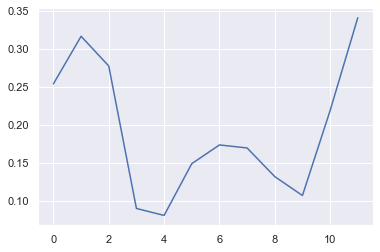

In [73]:
m_reg['r2'].plot()

No handles with labels found to put in legend.


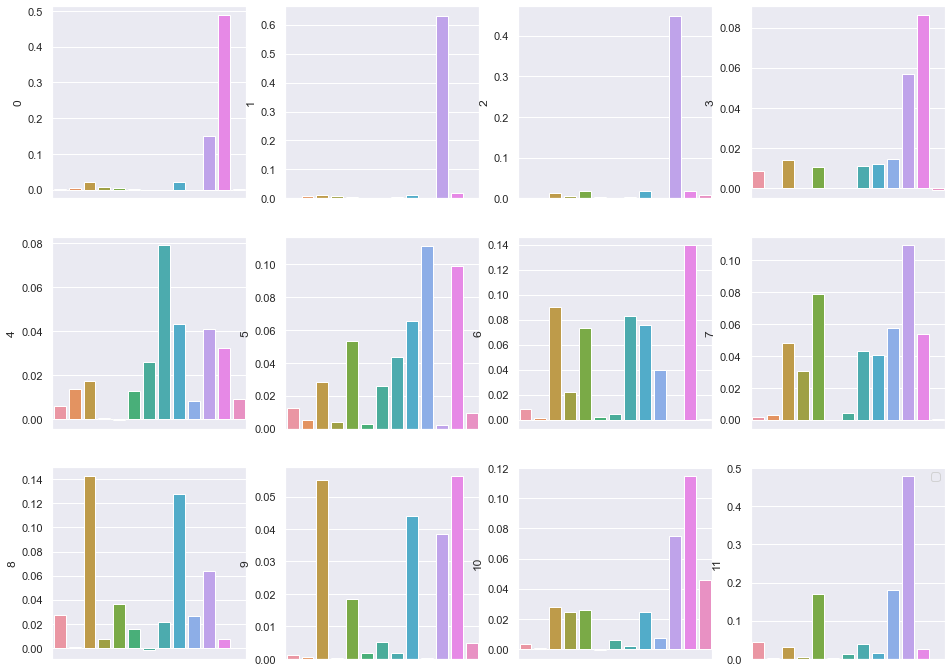

In [74]:
fig, ax = plt.subplots(3, 4, figsize=(16, 12))
i = 0
for month in range(1,13):
    g = sns.barplot(x=['fi_' + elem for elem in var], y=m_reg.loc[month-1, ['fi_' + elem for elem in var]],
                    ax=ax[i//4, i%4])
    g.set(xticklabels=[])
    i += 1
plt.legend()
plt.show()

<AxesSubplot:xlabel='month'>

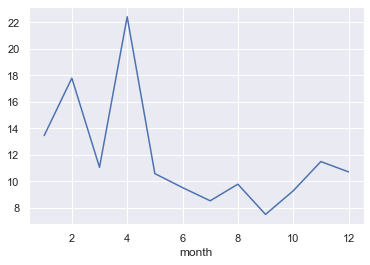

In [75]:
df.groupby('month').mean()['Value'].plot()

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183960 entries, 0 to 183959
Data columns (total 30 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Site             183960 non-null  object        
 1   DateTime         183960 non-null  datetime64[ns]
 2   Value            183960 non-null  float64       
 3   Gsp_area         183960 non-null  float64       
 4   Gsp_edge         183960 non-null  float64       
 5   RLA_Rd_len       183960 non-null  float64       
 6   pct_nRLA_Rd_Gsp  183960 non-null  float64       
 7   Mi_Rd_len        183960 non-null  float64       
 8   pct_nMi_Rd_Gsp   183960 non-null  float64       
 9   A_Rd_len         183960 non-null  float64       
 10  pct_nA_Rd_Gsp    183960 non-null  float64       
 11  L_Rd_len         183960 non-null  float64       
 12  pct_nL_Rd_Gsp    183960 non-null  float64       
 13  B_Rd_len         183960 non-null  float64       
 14  pct_nB_Rd_Gsp    183

In [81]:
high_period = df[df['month'].isin([1, 2, 4, 11])].drop(['hour','dayofweek','dayofmonth','month'],axis=1)
low_period = df[~df['month'].isin([1, 2, 4, 11])].drop(['hour','dayofweek','dayofmonth','month'],axis=1)

print('high period: '+str(high_period.shape)+'\nlow period: '+str(low_period.shape))

high period: (59976, 26)
low period: (123984, 26)


In [82]:
hp_X = high_period[var].values
hp_y = high_period['log_Value'].values

hp_X_train, hp_X_test, hp_y_train, hp_y_test = train_test_split(hp_X, hp_y, shuffle=True, random_state=25)
hp_X_train = scaler.fit_transform(hp_X_train)
hp_X_test = scaler.fit_transform(hp_X_test)
reg.fit(hp_X_train, hp_y_train)

get_importance(reg, hp_X_test, hp_y_test, feature_names=var)

([-6e-05,
  0.0011,
  0.01599,
  0.00436,
  0.00358,
  0.00018,
  0.00103,
  0.00316,
  0.0204,
  0.00071,
  0.15621,
  0.00023,
  0.01395],
 [0.00014,
  0.00035,
  0.0016,
  0.00091,
  0.0005,
  6e-05,
  0.00039,
  0.00065,
  0.00127,
  0.00018,
  0.00422,
  0.00037,
  0.00104])

In [83]:
reg.score(hp_X_test, hp_y_test)

0.10635610478494395

In [84]:
reg.coef_.tolist() + [reg.intercept_]

[0.026311274136606805,
 -0.07575467417716178,
 0.250877340391707,
 -0.2039499164542302,
 0.09096525249976296,
 0.011664456292906474,
 -0.0845695008921513,
 -0.1443467681590591,
 -0.3559767386795484,
 -0.03475934266785444,
 1.0864875049537068,
 0.12269121710025004,
 -1.1912172691468472,
 1.831665216171202]

In [85]:
lp_X = low_period[var].values
lp_y = low_period['log_Value'].values

lp_X_train, lp_X_test, lp_y_train, lp_y_test = train_test_split(lp_X, lp_y, shuffle=True, random_state=25)
lp_X_train = scaler.fit_transform(lp_X_train)
lp_X_test = scaler.fit_transform(lp_X_test)
reg.fit(lp_X_train, lp_y_train)

get_importance(reg, lp_X_test, lp_y_test, feature_names=var)

([0.00367,
  0.00076,
  0.04101,
  0.0045,
  0.03956,
  0.00487,
  0.00042,
  0.01251,
  0.04726,
  0.03051,
  0.12881,
  0.0021,
  3e-05],
 [0.0005,
  0.00017,
  0.00109,
  0.00049,
  0.00156,
  0.00054,
  0.00015,
  0.00085,
  0.00131,
  0.0013,
  0.00279,
  0.00026,
  1e-05])

In [86]:
reg.score(lp_X_test, lp_y_test)

0.10429978736321166

In [ ]:
reg.coef_.tolist() + [reg.intercept_]

# Mean analysis

In [87]:
hmean_df = df.groupby(['hour', 'Site']).mean()
hmean_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 504 entries, (0, 'BL0') to (23, 'TH4')
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Value            504 non-null    float64
 1   Gsp_area         504 non-null    float64
 2   Gsp_edge         504 non-null    float64
 3   RLA_Rd_len       504 non-null    float64
 4   pct_nRLA_Rd_Gsp  504 non-null    float64
 5   Mi_Rd_len        504 non-null    float64
 6   pct_nMi_Rd_Gsp   504 non-null    float64
 7   A_Rd_len         504 non-null    float64
 8   pct_nA_Rd_Gsp    504 non-null    float64
 9   L_Rd_len         504 non-null    float64
 10  pct_nL_Rd_Gsp    504 non-null    float64
 11  B_Rd_len         504 non-null    float64
 12  pct_nB_Rd_Gsp    504 non-null    float64
 13  LA_Rd_len        504 non-null    float64
 14  pct_nLA_Rd_Gsp   504 non-null    float64
 15  SA_Rd_len        504 non-null    float64
 16  pct_nSA_Rd_Gsp   504 non-null    float64
 17 

In [88]:
hmean_df.drop(['bp_mean', 'tmp_mean', 'Prec_mean', 'dayofweek', 'dayofmonth', 'month'], axis=1, inplace=True)

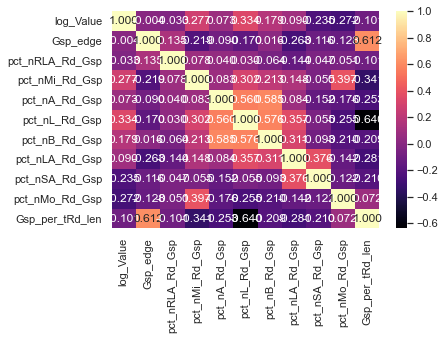

In [91]:
sns.heatmap(hmean_df[['log_Value']+exp_names].corr().round(4),annot=True,fmt='.3f',cmap='magma')
plt.show()

In [99]:
def get_corr(df,iter_range,method='pearson',features=exp_names,target='log_Value'):
    result=[]
    for index in iter_range:
        result.append(df.loc[(index,)].corr(method=method).loc[features,target])
    result=np.asarray(result)
    return result

In [100]:
def get_moran(df,iter_range,w=weight,target='log_Value'):
    result=[]
    for index in iter_range:
        result.append(Moran(df.loc[(index,),target].values,w).I)
    return result

In [133]:
def get_reg_info(df,iter_range,features=exp_names,target='log_Value',reg=LinearRegression()):
    result = []
    for index in iter_range:
        X = df.loc[(index,), features].values        
        y = df.loc[(index,), target].values
        
        X = scaler.fit_transform(X)
        
        reg.fit(X, y)
        coef = reg.coef_.tolist()
        coef.append(reg.score(X, y))
        importance, std = get_importance(reg, X, y, features)
        result.append(coef + importance + std)
    result = pd.DataFrame(result, columns=features+['score']+
                          ['fi_'+var for var in features]+['std_fi_'+var for var in features])
    return result

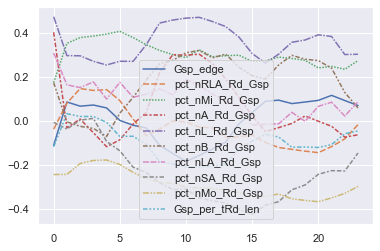

In [102]:
hmean_corr=get_corr(hmean_df,range(24))
sns.lineplot(data=hmean_corr,legend=False)
plt.legend(labels=exp_names)
plt.show()

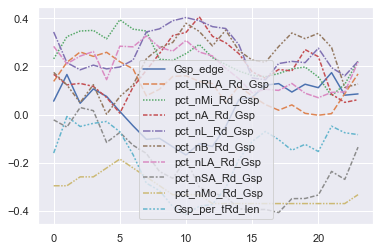

In [103]:
hmean_corr_sp=get_corr(hmean_df,range(24),method='spearman')
sns.lineplot(data=hmean_corr_sp,legend=False)
plt.legend(labels=exp_names)
plt.show()

<AxesSubplot:>

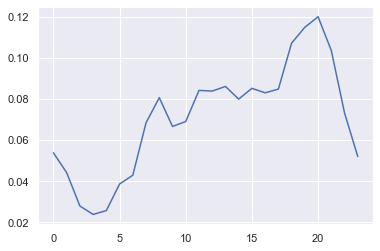

In [104]:
hmean_moran=get_moran(hmean_df,range(24))
sns.lineplot(x=range(24),y=hmean_moran)

<AxesSubplot:ylabel='score'>

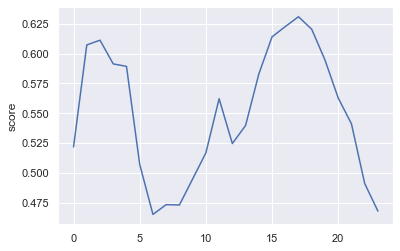

In [134]:
hmean_reg=get_reg_info(hmean_df,range(24))
sns.lineplot(x=range(24),y=hmean_reg['score'])

No handles with labels found to put in legend.


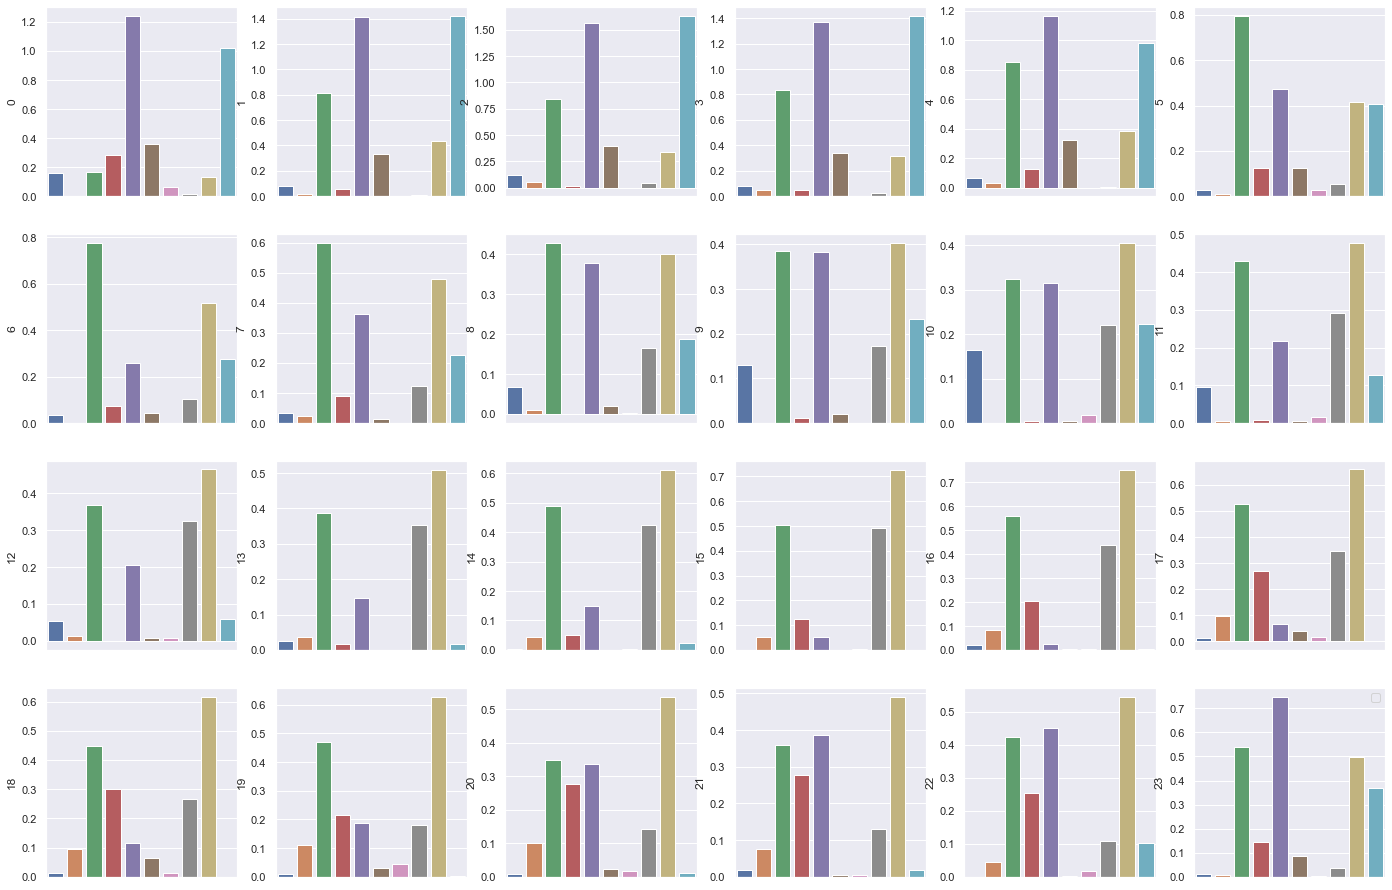

In [135]:
fig, ax = plt.subplots(4, 6, figsize=(24, 16))
i = 0
for hour in range(24):
    g = sns.barplot(x=['fi_' + elem for elem in exp_names], 
                    y=hmean_reg.loc[hour, ['fi_' + elem for elem in exp_names]],
                    ax=ax[i//6, i%6])
    g.set(xticklabels=[])
    i += 1
plt.legend()
plt.show()

In [128]:
hmean_reg

,Gsp_edge,pct_nRLA_Rd_Gsp,pct_nMi_Rd_Gsp,pct_nA_Rd_Gsp,pct_nL_Rd_Gsp,pct_nB_Rd_Gsp,pct_nLA_Rd_Gsp,pct_nSA_Rd_Gsp,pct_nMo_Rd_Gsp,Gsp_per_tRd_len,score
0,-0.220106,0.002007,0.177085,0.263388,0.464562,-0.280349,0.134387,0.059017,-0.243833,0.563998,0.521819
1,-0.112928,0.047509,0.292130,-0.105434,0.363870,-0.185323,0.011805,0.033652,-0.328290,0.472869,0.607160
2,-0.142983,0.096837,0.314286,-0.065674,0.405115,-0.217027,-0.002037,0.082216,-0.304258,0.541130,0.611149
3,-0.120603,0.091084,0.310186,-0.107299,0.375673,-0.198875,0.023767,0.065484,-0.296033,0.497118,0.591296
4,-0.105911,0.076646,0.313039,-0.163793,0.346424,-0.192245,-0.002595,-0.013549,-0.324601,0.411636,0.589255
5,-0.075469,0.044561,0.318118,-0.169142,0.231420,-0.127660,0.069128,-0.097483,-0.359997,0.275419,0.507233
6,-0.086928,-0.019959,0.323996,-0.139844,0.176553,-0.082441,0.017891,-0.140373,-0.414257,0.232605,0.465348
7,-0.089310,-0.073837,0.299027,-0.160937,0.220719,-0.050738,0.000418,-0.160610,-0.419704,0.221030,0.473528
8,-0.133775,-0.050460,0.266675,-0.035451,0.236461,-0.068771,0.023679,-0.199744,-0.406601,0.214367,0.473247
9,-0.199626,-0.018597,0.274690,0.037778,0.256773,-0.083504,0.007081,-0.225114,-0.443331,0.266788,0.495018


In [ ]:
# plot monthly mean
df.groupby('month').mean()['Value'].plot()

In [129]:
mmean_df=df.groupby(['month','Site']).mean()
mmean_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 252 entries, (1, 'BL0') to (12, 'TH4')
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Value            252 non-null    float64
 1   Gsp_area         252 non-null    float64
 2   Gsp_edge         252 non-null    float64
 3   RLA_Rd_len       252 non-null    float64
 4   pct_nRLA_Rd_Gsp  252 non-null    float64
 5   Mi_Rd_len        252 non-null    float64
 6   pct_nMi_Rd_Gsp   252 non-null    float64
 7   A_Rd_len         252 non-null    float64
 8   pct_nA_Rd_Gsp    252 non-null    float64
 9   L_Rd_len         252 non-null    float64
 10  pct_nL_Rd_Gsp    252 non-null    float64
 11  B_Rd_len         252 non-null    float64
 12  pct_nB_Rd_Gsp    252 non-null    float64
 13  LA_Rd_len        252 non-null    float64
 14  pct_nLA_Rd_Gsp   252 non-null    float64
 15  SA_Rd_len        252 non-null    float64
 16  pct_nSA_Rd_Gsp   252 non-null    float64
 17 

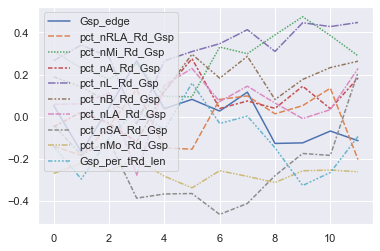

In [120]:
mmean_corr=get_corr(mmean_df,range(1,13))
sns.lineplot(data=mmean_corr,legend=False)
plt.legend(labels=exp_names,loc='upper left')
plt.show()

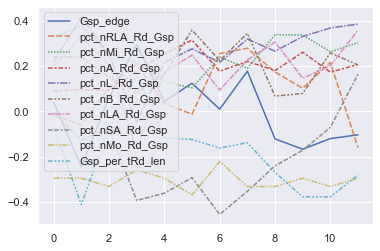

In [121]:
mmean_corr_sp=get_corr(mmean_df,range(1,13),method='spearman')
sns.lineplot(data=mmean_corr_sp,legend=False)
plt.legend(labels=exp_names,loc='upper left')
plt.show()

<AxesSubplot:>

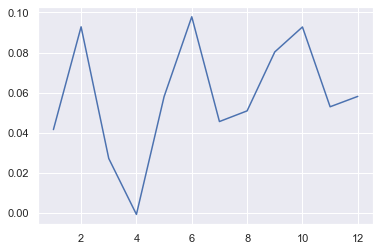

In [122]:
mmean_moran=get_moran(mmean_df,range(1,13))
sns.lineplot(x=range(1,13),y=mmean_moran)

<AxesSubplot:ylabel='score'>

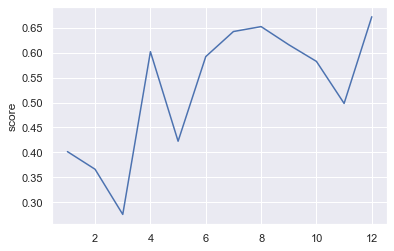

In [136]:
mmean_reg=get_reg_info(mmean_df,range(1,13))
sns.lineplot(x=range(1,13),y=mmean_reg['score'])

No handles with labels found to put in legend.


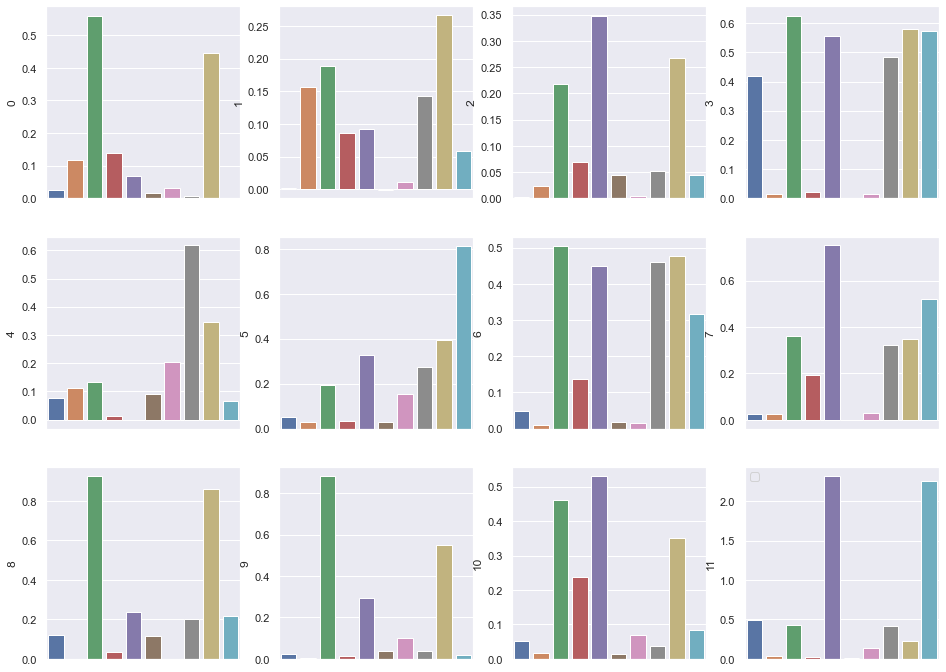

In [137]:
fig, ax = plt.subplots(3, 4, figsize=(16, 12))
i = 0
for month in range(1,13):
    g = sns.barplot(x=['fi_' + elem for elem in exp_names], 
                    y=mmean_reg.loc[month-1, ['fi_' + elem for elem in exp_names]],
                    ax=ax[i//4, i%4])
    g.set(xticklabels=[])
    i += 1
plt.legend()
plt.show()

In [131]:
# identify high period and low period
high=df[df['month'].isin([1,2,3,4])].groupby('Site').mean()
low=df[~df['month'].isin([1,2,3,4])].groupby('Site').mean()

print('high: '+str(high.shape)+'\nlow: '+str(low.shape))

high: (21, 28)
low: (21, 28)


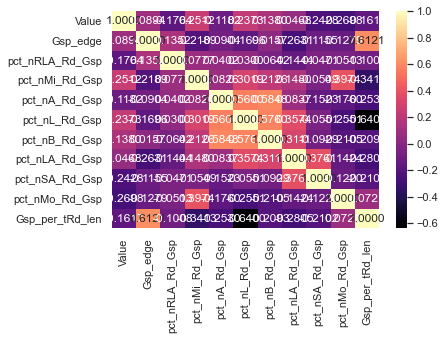

In [132]:
sns.heatmap(high[['Value']+exp_names].corr().round(4),annot=True,fmt='.4f',cmap='magma')
plt.show()

In [ ]:
high_moran=Moran(high['Value'].values,weight)
round(high_moran.I,5)

In [ ]:
reg_high=LinearRegression()
y_high = high['Value'].values
x_high = high[exp_names].values
reg_high.fit(x_high, y_high)
reg_high.score(x_high,y_high)

In [ ]:
prd_high = reg_high.predict(x_high)

r = stats.pearsonr(y_high, prd_high)[0]
r2 = r**2
t, p_value = stats.kendalltau(y_high, prd_high)
print('r2 (obs): ', round(r2, 5))
print('tau (obs): ', round(t, 5))

In [ ]:
cv_r2_high = []
cv_tau_high = []

for i in range(100):
    kf = KFold(n_splits=4, shuffle=True, random_state=i)
    cvprd_high = cross_val_predict(reg_high, x_high, y_high, cv=kf)  #predict using current random folds
    
    #correlations
    r = stats.pearsonr(y_high,cvprd_high)[0]
    t, p_value = stats.kendalltau(y_high, prd_high)
    
    #append to list
    cv_r2_high.append(r**2)
    cv_tau_high.append(t)

print('r2 (cv): ', round(np.mean(cv_r2_high), 5))
print('tau (cv): ', round(np.mean(cv_tau_high),5))
print('r2 variance (cv): ', 1.96 * np.var(cv_r2_high))
print('tau variance (cv): ', 1.96 * np.var(cv_tau_high))

In [ ]:
sns.heatmap(low[['Value']+exp_names].corr().round(4),annot=True,fmt='.4f',cmap='magma')
plt.show()

In [ ]:
low_moran=Moran(low['Value'].values,weight)
round(low_moran.I,5)

In [ ]:
reg_low = LinearRegression()
y_low = low['Value'].values
x_low = low[exp_names].values
reg_low.fit(x_low, y_low)
prd_low = reg_low.predict(x_low)

r = low['Value'].corr(pd.Series(prd_low))
r2 = r**2
t = low['Value'].corr(pd.Series(prd_low), method='kendall')
print("r2 (cv): ", round(r2,3))   
print("tau (cv): ", round(t,3))

In [ ]:
sns.heatmap(all[['Value']+exp_names].corr().round(4),annot=True,fmt='.4f',cmap='magma')
plt.show()

In [ ]:
all=df.groupby('Site').mean()
all_moran=Moran(all['Value'].values,weight)
round(all_moran.I,5)

In [ ]:
y_all=(all.groupby('Site').mean()['Value'].values)
x_all=(all.groupby('Site').mean()[exp_names].values)

reg.fit(x_all,y_all)
reg.score(x_all,y_all)